Goal with this data is to

1.) Identify high-impact NAICS codes
    We can identify top industries by 
        # of establishments
        annual pay
        number of employees
        calculate LQ values by comparing to national data
            LQ values are (Regional share of industry employment) / (National share of industry employment) 

2.) With these 20-30 high-impact industries, we can look into zip-code level data and then plot (somehow) their distribution.
    This can help us identify patterns such as industry clusters and overlaps.
    Try to use geopandas for plotting

3.) Census data can also provide us MRF/waste disposal facilities (look into this some more)

4.) EPA data also provides some insight into MRFs (but I am not fully sure how they categorize them and select them) 
    More research will have to be done to cross compare Census data to EPA data

5.) Big question to figure out is is the amount of MRFs balanced regionally? (could we even figure this out with this data?)
    Are there any gaps in our current infrastructure?
    *** what is the nomenclature for MRF NAICS codes?

6.) Take the MAESTRI and ISDATA from european symbiosis examples, translate their NACE codes into NAICS codes using chatGPT
    Select high impact WA NAICS codes
        Using historical symbiosis connections 
        Find biggest opportunities in our state

*** there is an EIA dataset on energy consuption by industry, do we want to integrate this as well?
    high energy consumption could potentially make a company "higher impact"
    

In [1]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local
from esda.getisord import G_Local
import warnings
warnings.filterwarnings('ignore')


1.) Pull WA state manufacturing data and national manufacturing data from US County Buisiness Patterns dataset

In [2]:
## retrieve national data
def get_national_manufacturing_data():
    """Get US national manufacturing data for Location Quotient calculations"""
    variables = ['NAME', 'NAICS2017', 'NAICS2017_LABEL', 'ESTAB', 'EMP', 'PAYANN']
    url = f"https://api.census.gov/data/2023/cbp?get={','.join(variables)}&for=us:1&NAICS2017=3*"
    
    try:
        response = requests.get(url)
        print(f"National data status: {response.status_code}")
        
        if response.status_code == 200:
            data = response.json()
            df = pd.DataFrame(data[1:], columns=data[0])
            return df
        else:
            print("Failed to get national data")
            return None
    except Exception as e:
        print(f"Error getting national data: {e}")
        return None

In [3]:
#retrieve washington data 
def get_wa_state_manufacturing_data():
    """Get Washington STATE-level manufacturing data (not county-level)"""
    variables = ['NAME', 'NAICS2017', 'NAICS2017_LABEL', 'ESTAB', 'EMP', 'PAYANN']
    # Changed from county:* to state:53 to get state-level aggregates
    url = f"https://api.census.gov/data/2023/cbp?get={','.join(variables)}&for=state:53&NAICS2017=3*"
    
    try:
        response = requests.get(url)
        print(f"WA state data status: {response.status_code}")
        
        if response.status_code == 200:
            data = response.json()
            df = pd.DataFrame(data[1:], columns=data[0])
            print(f"Retrieved {len(df)} WA state-level records")
            return df
        else:
            print("Failed to get WA state data")
            return None
    except Exception as e:
        print(f"Error getting WA state data: {e}")
        return None

In [4]:
wa_data = get_wa_state_manufacturing_data()
wa_data = wa_data.loc[:, ~wa_data.columns.duplicated()]



WA state data status: 200
Retrieved 534 WA state-level records


In [5]:
wa_data[['ESTAB', 'EMP', 'PAYANN']] = wa_data[['ESTAB', 'EMP', 'PAYANN']].apply(pd.to_numeric, errors='coerce')
print(wa_data)

wa_data['NAICS2017'] = wa_data['NAICS2017'].astype(str)
wa_data_3digit = wa_data[wa_data['NAICS2017'].str.len() == 3]
wa_data_4digit = wa_data[wa_data['NAICS2017'].str.len() == 4]
wa_data_6digit = wa_data[wa_data['NAICS2017'].str.len() == 6]

print('total establishments recorded by 3-digit NAICS', wa_data_3digit['ESTAB'].sum())
print('total establishments recorded by 4-digit NAICS', wa_data_4digit['ESTAB'].sum())
print('total establishments recorded by 6-digit NAICS', wa_data_6digit['ESTAB'].sum())


           NAME NAICS2017                                NAICS2017_LABEL  \
0    Washington     31-33                                  Manufacturing   
1    Washington       311                             Food manufacturing   
2    Washington      3111                      Animal food manufacturing   
3    Washington      3113  Sugar and confectionery product manufacturing   
4    Washington     31111                      Animal food manufacturing   
..          ...       ...                                            ...   
529  Washington    339910           Jewelry and silverware manufacturing   
530  Washington     33992      Sporting and athletic goods manufacturing   
531  Washington    339920      Sporting and athletic goods manufacturing   
532  Washington     33994   Office supplies (except paper) manufacturing   
533  Washington    339940   Office supplies (except paper) manufacturing   

     ESTAB     EMP    PAYANN state  
0     6586  264782  23654282    53  
1      885   

will start off with analysis for 4-digit NAICS codes

In [6]:
print(wa_data_4digit)
print("Total Establishments:", wa_data_4digit['ESTAB'].sum())
print("Total Industries:", wa_data_4digit['NAICS2017'].nunique())

           NAME NAICS2017                                    NAICS2017_LABEL  \
2    Washington      3111                          Animal food manufacturing   
3    Washington      3113      Sugar and confectionery product manufacturing   
7    Washington      3112                          Grain and oilseed milling   
21   Washington      3119                           Other food manufacturing   
28   Washington      3114  Fruit and vegetable preserving and specialty f...   
..          ...       ...                                                ...   
492  Washington      3366                             Ship and boat building   
495  Washington      3369       Other transportation equipment manufacturing   
509  Washington      3379      Other furniture related product manufacturing   
512  Washington      3391       Medical equipment and supplies manufacturing   
527  Washington      3399                  Other miscellaneous manufacturing   

     ESTAB   EMP  PAYANN state  
2     

In [7]:
## identify most relevant sectors by # of establishments, # of employees, 
wa_data_top_est = wa_data_4digit.sort_values(by='ESTAB', ascending=False).head(20)
print(wa_data_top_est)

wa_data_top_emp = wa_data_4digit.sort_values(by='EMP', ascending=False).head(20)
print(wa_data_top_emp)



           NAME NAICS2017                                    NAICS2017_LABEL  \
69   Washington      3121                             Beverage manufacturing   
328  Washington      3327  Machine shops; turned product; and screw, nut,...   
58   Washington      3118                Bakeries and tortilla manufacturing   
185  Washington      3231            Printing and related support activities   
527  Washington      3399                  Other miscellaneous manufacturing   
292  Washington      3323  Architectural and structural metals manufacturing   
512  Washington      3391       Medical equipment and supplies manufacturing   
468  Washington      3371  Household and institutional furniture and kitc...   
109  Washington      3219                   Other wood product manufacturing   
223  Washington      3261                     Plastics product manufacturing   
402  Washington      3345  Navigational, measuring, electromedical, and c...   
254  Washington      3273          Cemen

In [8]:
nat_data = get_national_manufacturing_data()

National data status: 200


In [9]:
# basically complete same as above 
nat_data = nat_data.loc[:, ~nat_data.columns.duplicated()]

nat_data[['ESTAB', 'EMP', 'PAYANN']] = nat_data[['ESTAB', 'EMP', 'PAYANN']].apply(pd.to_numeric, errors='coerce')
print(nat_data)
print(nat_data['ESTAB'].sum())

nat_data['NAICS2017'] = nat_data['NAICS2017'].astype(str)
nat_data_3digit = nat_data[nat_data['NAICS2017'].str.len() == 3]
nat_data_4digit = nat_data[nat_data['NAICS2017'].str.len() == 4]
nat_data_6digit = nat_data[nat_data['NAICS2017'].str.len() == 6]

print('total establishments recorded by 3-digit NAICS', nat_data_3digit['ESTAB'].sum())
print('total establishments recorded by 4-digit NAICS', nat_data_4digit['ESTAB'].sum())
print('total establishments recorded by 6-digit NAICS', nat_data_6digit['ESTAB'].sum())

print(nat_data_4digit)
print("Total Establishments:", nat_data_4digit['ESTAB'].sum())
print("Total Industries:", nat_data_4digit['NAICS2017'].nunique())

              NAME NAICS2017  \
0    United States     31-33   
1    United States       311   
2    United States      3111   
3    United States    311221   
4    United States    311224   
..             ...       ...   
643  United States     33999   
644  United States    339991   
645  United States    339992   
646  United States    339999   
647  United States    339995   

                                       NAICS2017_LABEL   ESTAB       EMP  \
0                                        Manufacturing  284452  12335234   
1                                   Food manufacturing   31130   1707316   
2                            Animal food manufacturing    1914     64800   
3                                     Wet corn milling      70      7467   
4                 Soybean and other oilseed processing     190     10887   
..                                                 ...     ...       ...   
643              All other miscellaneous manufacturing    4547     99947   
644  Ga

In [10]:
def calculate_location_quotients(wa_data, national_data):
    """Calculate proper Location Quotients using national benchmarks"""
    
    print("\n=== Location Quotient Analysis ===")
    
    # Prepare Washington data - sum across all counties for each industry
    wa_by_industry = wa_data.groupby('NAICS2017')['EMP'].sum().reset_index()
    wa_total_emp = wa_by_industry['EMP'].sum()
    wa_by_industry['WA_SHARE'] = wa_by_industry['EMP'] / wa_total_emp
    
    print(f"Washington total manufacturing employment: {wa_total_emp:,}")
    
    # Prepare national data
    national_by_industry = national_data.groupby('NAICS2017')['EMP'].sum().reset_index()
    national_total_emp = national_by_industry['EMP'].sum()
    national_by_industry['NATIONAL_SHARE'] = national_by_industry['EMP'] / national_total_emp
    
    print(f"US total manufacturing employment: {national_total_emp:,}")
    
    # Merge and calculate Location Quotients
    lq_analysis = wa_by_industry.merge(
        national_by_industry[['NAICS2017', 'NATIONAL_SHARE']], 
        on='NAICS2017', 
        how='inner'
    )
    
    # Calculate LQ = (WA share) / (National share)
    lq_analysis['LOCATION_QUOTIENT'] = lq_analysis['WA_SHARE'] / lq_analysis['NATIONAL_SHARE']
    
    # Add industry labels
    industry_labels = wa_data[['NAICS2017', 'NAICS2017_LABEL']].drop_duplicates()
    lq_analysis = lq_analysis.merge(industry_labels, on='NAICS2017', how='left')
    
    # Find specializations (LQ > 1.0)
    specializations = lq_analysis[lq_analysis['LOCATION_QUOTIENT'] > 1.0].copy()
    specializations = specializations.sort_values('LOCATION_QUOTIENT', ascending=False)
    
    print(f"\nWashington Manufacturing Specializations (LQ > 1.0):")
    print(f"Found {len(specializations)} specialized industries")
    print("\nTop 15 Specializations:")
    
    for _, row in specializations.head(15).iterrows():
        print(f"• LQ {row['LOCATION_QUOTIENT']:>5.2f} | {row['NAICS2017_LABEL'][:55]:<55} | {row['EMP']:>8,} jobs")
    
    return lq_analysis, specializations

In [11]:
calculate_location_quotients(wa_data_4digit, nat_data_4digit)


=== Location Quotient Analysis ===
Washington total manufacturing employment: 264,717
US total manufacturing employment: 12,335,234

Washington Manufacturing Specializations (LQ > 1.0):
Found 22 specialized industries

Top 15 Specializations:
• LQ  7.87 | Aerospace product and parts manufacturing               |   72,423 jobs
• LQ  7.68 | Seafood product preparation and packaging               |    4,800 jobs
• LQ  2.83 | Sawmills and wood preservation                          |    5,573 jobs
• LQ  2.78 | Fruit and vegetable preserving and specialty food manuf |    9,952 jobs
• LQ  1.90 | Pulp, paper, and paperboard mills                       |    3,708 jobs
• LQ  1.56 | Beverage manufacturing                                  |    9,361 jobs
• LQ  1.40 | Audio and video equipment manufacturing                 |      329 jobs
• LQ  1.30 | Lime and gypsum product manufacturing                   |      433 jobs
• LQ  1.30 | Ship and boat building                                  |    4,

(   NAICS2017   EMP  WA_SHARE  NATIONAL_SHARE  LOCATION_QUOTIENT  \
 0       3111   738  0.002788        0.005253           0.530697   
 1       3112   843  0.003185        0.005184           0.614299   
 2       3113  1154  0.004359        0.006955           0.626837   
 3       3114  9952  0.037595        0.013533           2.777960   
 4       3115  1651  0.006237        0.013329           0.467917   
 ..       ...   ...       ...             ...                ...   
 77      3371  3733  0.014102        0.017669           0.798114   
 78      3372  1230  0.004646        0.008490           0.547304   
 79      3379   526  0.001987        0.002669           0.744546   
 80      3391  3565  0.013467        0.025001           0.538676   
 81      3399  4214  0.015919        0.020227           0.786998   
 
                                       NAICS2017_LABEL  
 0                           Animal food manufacturing  
 1                           Grain and oilseed milling  
 2       Su

In [12]:
_, specializations = calculate_location_quotients(wa_data_4digit, nat_data_4digit)



=== Location Quotient Analysis ===
Washington total manufacturing employment: 264,717
US total manufacturing employment: 12,335,234

Washington Manufacturing Specializations (LQ > 1.0):
Found 22 specialized industries

Top 15 Specializations:
• LQ  7.87 | Aerospace product and parts manufacturing               |   72,423 jobs
• LQ  7.68 | Seafood product preparation and packaging               |    4,800 jobs
• LQ  2.83 | Sawmills and wood preservation                          |    5,573 jobs
• LQ  2.78 | Fruit and vegetable preserving and specialty food manuf |    9,952 jobs
• LQ  1.90 | Pulp, paper, and paperboard mills                       |    3,708 jobs
• LQ  1.56 | Beverage manufacturing                                  |    9,361 jobs
• LQ  1.40 | Audio and video equipment manufacturing                 |      329 jobs
• LQ  1.30 | Lime and gypsum product manufacturing                   |      433 jobs
• LQ  1.30 | Ship and boat building                                  |    4,

In [13]:
specialty_naics = specializations['NAICS2017'].tolist()

In [14]:
print(specialty_naics)

['3364', '3117', '3211', '3114', '3221', '3121', '3343', '3274', '3366', '3344', '3332', '3212', '3345', '3162', '3253', '3241', '3342', '3149', '3254', '3272', '3118', '3323']


2.) Now that we've identified top industries of industries of interest in terms of location quotients, we can plot clusters using zip-code level data.
Thinking to do a heatmap showing which of these industries are located.

Also want to look into these statistical techniques to demonstrate overlap between sectors geographically: 

Cross-correlation (which industries co-locate?), 
Moran's I (which industries cluster geographically?), 
LISA/G* (where are the clusters?)

In [15]:
def get_county_manufacturing_data():
    """Get all manufacturing data for Washington counties"""
    variables = ['NAME', 'NAICS2017', 'NAICS2017_LABEL', 'ESTAB', 'EMP']
    url = f"https://api.census.gov/data/2023/cbp?get={','.join(variables)}&for=county:*&in=state:53&NAICS2017=3*"

    try:
        response = requests.get(url)
        print(f"County data status: {response.status_code}")

        if response.status_code == 200:
            data = response.json()
            df = pd.DataFrame(data[1:], columns=data[0])
            print(f"DataFrame created with shape: {df.shape}")  # Debug line
            return df
        else:
            print("Failed to get county data")
            return None
    except Exception as e:
        print(f"Error getting county data: {e}")
        return None

# Call it properly
county_data = get_county_manufacturing_data()

County data status: 200
DataFrame created with shape: (2005, 8)


In [16]:
print(county_data)

                           NAME NAICS2017  \
0      Adams County, Washington     31-33   
1      Adams County, Washington       311   
2      Adams County, Washington      3111   
3      Adams County, Washington     31111   
4      Adams County, Washington    311119   
...                         ...       ...   
2000  Yakima County, Washington     33911   
2001  Yakima County, Washington    339116   
2002  Yakima County, Washington    339950   
2003  Yakima County, Washington      3399   
2004  Yakima County, Washington     33995   

                                   NAICS2017_LABEL ESTAB   EMP NAICS2017  \
0                                    Manufacturing    15  1140     31-33   
1                               Food manufacturing    11  1118       311   
2                        Animal food manufacturing     3    39      3111   
3                        Animal food manufacturing     3    39     31111   
4                  Other animal food manufacturing     3    39    311119   
...

In [ ]:
county_data = county_data.loc[:, ~county_data.columns.duplicated()]
# ──────────────────────────────────────────────────────────────
#  A.  Prep: keep only 4-digit manufacturing rows
# ──────────────────────────────────────────────────────────────
county_data['NAICS2017'] = county_data['NAICS2017'].astype(str)
county_4 = county_data[
    county_data['NAICS2017'].str.match(r'^\d{4}$') &   # 4-digit
    county_data['NAICS2017'].str.startswith(('31','32','33'))
].copy()

# convert EMP to int just in case
county_4['EMP'] = pd.to_numeric(county_4['EMP'], errors='coerce').fillna(0).astype(int)

# ──────────────────────────────────────────────────────────────
# B.  County-level Location Quotients
#     LQ = (industry share in county) / (industry share in U.S.)
# ──────────────────────────────────────────────────────────────
# 1. total manu employment **per county**
county_tot = (
    county_4.groupby('county', as_index=False)['EMP']
            .sum()
            .rename(columns={'EMP': 'EMP_total_county'})
)

# 2. attach county totals to every county-industry record
county_ind = county_4.merge(county_tot, on='county')

# 3. national employment for each 4-digit NAICS
nat_emp = (
    nat_data_4digit[['NAICS2017', 'EMP']]
      .copy()
      .rename(columns={'EMP': 'EMP_nat'})
      .set_index('NAICS2017')
)
nat_total_emp = nat_emp['EMP_nat'].sum()

# 4. add national employment to county table
county_ind = county_ind.merge(
    nat_emp, how='left', left_on='NAICS2017', right_index=True
).fillna({'EMP_nat': 0})

# 5. compute LQ
county_ind['LQ'] = (
    (county_ind['EMP'] / county_ind['EMP_total_county']) /
    (county_ind['EMP_nat'] / nat_total_emp)
)

# 6. optional “strong cluster” flag
county_ind['cluster_flag'] = (county_ind['LQ'] >= 1.25).astype(int)

# final tidy dataframe
county_lq = county_ind[['NAME', 'county', 'NAICS2017', 'NAICS2017_LABEL', 'EMP', 'LQ', 'cluster_flag']]

print(county_lq.head())

                        NAME county NAICS2017  \
0   Adams County, Washington    001      3111   
1   Adams County, Washington    001      3114   
2  Asotin County, Washington    003      3366   
3  Benton County, Washington    005      3114   
4  Benton County, Washington    005      3118   

                                     NAICS2017_LABEL   EMP         LQ  \
0                          Animal food manufacturing    39   6.829792   
1  Fruit and vegetable preserving and specialty f...  1048  71.240856   
2                             Ship and boat building   240  81.895845   
3  Fruit and vegetable preserving and specialty f...  1122  22.179459   
4                Bakeries and tortilla manufacturing   157   1.628071   

   cluster_flag  
0             1  
1             1  
2             1  
3             1  
4             1  


In [18]:
print(county_lq)

                           NAME county NAICS2017  \
0      Adams County, Washington    001      3111   
1      Adams County, Washington    001      3114   
2     Asotin County, Washington    003      3366   
3     Benton County, Washington    005      3114   
4     Benton County, Washington    005      3118   
..                          ...    ...       ...   
506  Whatcom County, Washington    073      3372   
507  Whatcom County, Washington    073      3391   
508  Whatcom County, Washington    073      3399   
509   Yakima County, Washington    077      3391   
510   Yakima County, Washington    077      3399   

                                       NAICS2017_LABEL   EMP         LQ  \
0                            Animal food manufacturing    39   6.829792   
1    Fruit and vegetable preserving and specialty f...  1048  71.240856   
2                               Ship and boat building   240  81.895845   
3    Fruit and vegetable preserving and specialty f...  1122  22.179459   


In [19]:
county_4['ESTAB'] = pd.to_numeric(county_4['ESTAB'], errors='coerce')
print(county_4['ESTAB'].sum())

5746


In [20]:
def calculate_industry_correlations(county_4):
    """Calculate correlations between industries using establishment counts"""
    
    # Create pivot table: counties as rows, industries as columns, establishments as values
    pivot_data = county_4.pivot_table(
        index='county', 
        columns='NAICS2017', 
        values='ESTAB', 
        fill_value=0
    )
    
    print(f"Correlation matrix shape: {pivot_data.shape}")
    print(f"Counties: {len(pivot_data)}")
    print(f"Industries: {len(pivot_data.columns)}")
    
    # Calculate correlation matrix
    correlation_matrix = pivot_data.corr()
    
    # Get industry pairs with high correlations (>0.5)
    high_correlations = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            industry1 = correlation_matrix.columns[i]
            industry2 = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            
            if abs(corr_value) > 0.5 and not pd.isna(corr_value):
                high_correlations.append({
                    'Industry1': industry1,
                    'Industry2': industry2,
                    'Correlation': corr_value
                })
    
    # Convert to DataFrame and sort
    corr_df = pd.DataFrame(high_correlations)
    if not corr_df.empty:
        corr_df = corr_df.sort_values('Correlation', key=abs, ascending=False)
    
    return correlation_matrix, corr_df, pivot_data


In [21]:
# First, let's diagnose the data before running correlations
print("=== Data Diagnosis ===")
print(f"Total records in county_data: {len(county_4)}")
print(f"Unique counties: {county_4['county'].nunique()}")
print(f"Unique industries: {county_4['NAICS2017'].nunique()}")

# Check for data sparsity
pivot_data_check = county_4.pivot_table(
    index='county', 
    columns='NAICS2017', 
    values='ESTAB', 
    fill_value=0
)

print(f"\nPivot table shape: {pivot_data_check.shape}")
print("Non-zero values per industry:")
for col in pivot_data_check.columns:
    non_zero = (pivot_data_check[col] > 0).sum()
    print(f"  {col}: {non_zero}/{len(pivot_data_check)} counties have this industry")

=== Data Diagnosis ===
Total records in county_data: 511
Unique counties: 33
Unique industries: 77

Pivot table shape: (33, 77)
Non-zero values per industry:
  3111: 7/33 counties have this industry
  3112: 3/33 counties have this industry
  3113: 4/33 counties have this industry
  3114: 10/33 counties have this industry
  3115: 5/33 counties have this industry
  3116: 8/33 counties have this industry
  3117: 5/33 counties have this industry
  3118: 21/33 counties have this industry
  3119: 12/33 counties have this industry
  3121: 31/33 counties have this industry
  3141: 1/33 counties have this industry
  3149: 11/33 counties have this industry
  3152: 5/33 counties have this industry
  3159: 1/33 counties have this industry
  3162: 1/33 counties have this industry
  3169: 2/33 counties have this industry
  3211: 14/33 counties have this industry
  3212: 8/33 counties have this industry
  3219: 21/33 counties have this industry
  3221: 2/33 counties have this industry
  3222: 6/33 co

Correlation matrix shape: (33, 77)
Counties: 33
Industries: 77

=== Correlation Results (High LQ + Multi-County) ===
High correlation pairs (|correlation| > 0.4):
Correlation:  1.000 | 3274 <-> 3351
    Lime and gypsum product manufacturing
    Electric lighting equipment manufacturing

Correlation:  1.000 | 3274 <-> 3341
    Lime and gypsum product manufacturing
    Computer and peripheral equipment manufacturing

Correlation:  1.000 | 3351 <-> 3352
    Electric lighting equipment manufacturing
    Household appliance manufacturing

Correlation:  1.000 | 3351 <-> 3361
    Electric lighting equipment manufacturing
    Motor vehicle manufacturing

Correlation:  1.000 | 3271 <-> 3352
    Clay product and refractory manufacturing
    Household appliance manufacturing

Correlation:  1.000 | 3271 <-> 3361
    Clay product and refractory manufacturing
    Motor vehicle manufacturing

Correlation:  1.000 | 3341 <-> 3352
    Computer and peripheral equipment manufacturing
    Household applian

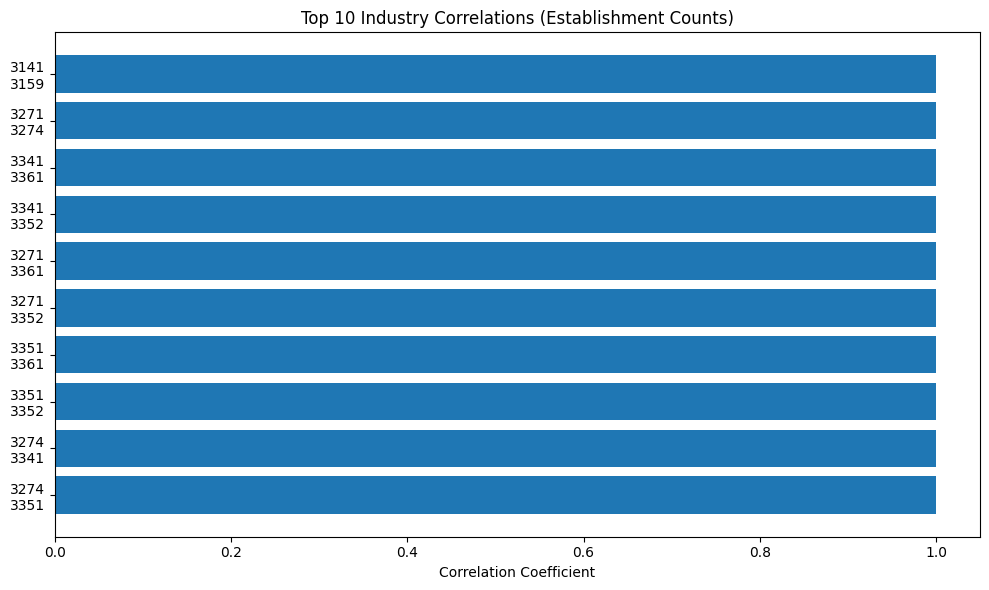

In [22]:
# %%
# Run correlation analysis on filtered data
correlation_matrix, high_corr_pairs, pivot_data = calculate_industry_correlations(county_4)

print("\n=== Correlation Results (High LQ + Multi-County) ===")
print("High correlation pairs (|correlation| > 0.4):")
if not high_corr_pairs.empty:
    # Also add industry labels for readability
    industry_labels = county_data[['NAICS2017', 'NAICS2017_LABEL']].drop_duplicates()
    
    for _, row in high_corr_pairs.head(15).iterrows():
        label1 = industry_labels[industry_labels['NAICS2017'] == row['Industry1']]['NAICS2017_LABEL'].iloc[0] if len(industry_labels[industry_labels['NAICS2017'] == row['Industry1']]) > 0 else row['Industry1']
        label2 = industry_labels[industry_labels['NAICS2017'] == row['Industry2']]['NAICS2017_LABEL'].iloc[0] if len(industry_labels[industry_labels['NAICS2017'] == row['Industry2']]) > 0 else row['Industry2']
        
        print(f"Correlation: {row['Correlation']:>6.3f} | {row['Industry1']} <-> {row['Industry2']}")
        print(f"    {label1[:50]}")
        print(f"    {label2[:50]}")
        print()
else:
    print("No high correlations found - try lowering threshold to 0.3")

# %%
# Quick visualization of top correlations
if not high_corr_pairs.empty:
    plt.figure(figsize=(10, 6))
    top_10 = high_corr_pairs.head(10)
    
    # Create industry pair labels
    pair_labels = [f"{row['Industry1']}\n{row['Industry2']}" for _, row in top_10.iterrows()]
    
    plt.barh(range(len(top_10)), top_10['Correlation'])
    plt.yticks(range(len(top_10)), pair_labels)
    plt.xlabel('Correlation Coefficient')
    plt.title('Top 10 Industry Correlations (Establishment Counts)')
    plt.tight_layout()
    plt.show()

4? This is EPA dataset stuff

In [23]:
import geopandas as gpd
from fiona import listlayers

gdb_path = r"C:\Users\masha\Documents\RecyclingInfrastructure_20220314.gdb"

# List all layers in the gdb
print(listlayers(gdb_path))

['ElectronicsRecyclers', 'GlassRecyclingFacilities', 'GlassSecondaryProcessors', 'MRFs', 'PaperRecyclingFacilities', 'PlasticRecyclingFacilities', 'TextilesRecyclingFacilities', 'WoodRecyclingFacilities', 'WoodSecondaryProcessors']


In [24]:
df = gpd.read_file(gdb_path, layer='MRFs')


In [25]:
print(df)

                                               Name  \
0                          A & W Iron & Metal, Inc.   
1                    A-1 Recycling-Div of The Peltz   
2     Accura Paper Recycling Inc (Waste Management)   
3                        Action Environmental Group   
4                     Adams Brown Recycling Station   
..                                              ...   
416                 WM River Hills Recycling Center   
417                          WM RRT Springfield MRF   
418        WM Salt Lake Commercial Recycling Center   
419  York County Solid Waste Collection & Recycling   
420                       ZWS Waste Solutions, LLCA   

                                             Address   County       TELEPHONE  \
0             7588 Otten Ln, Kewaskum, WI, 530409400                            
1        2020 W Morgan Ave, Milwaukee, WI, 532211533                            
2         7900 Sloane Dr, Little Rock, AR, 722063893  Pulaski  (501) 490-0733   
3              

In [26]:
# load county shapefile
wa_county = gpd.read_file(r"C:\Users\masha\Downloads\WA_County_Boundaries\WA_County_Boundaries.shp")

print(wa_county)

    OBJECTID  JURISDICT_  JURISDIC_1    JURISDIC_2           JURISDIC_3  \
0    1152816          25           4         Grant         Grant County   
1    1156970          33           4      Garfield      Garfield County   
2    1157332           8           4        Island        Island County   
3    1157955     4699350           4      Kittitas      Kittitas County   
4    1157997          35           4   Walla Walla   Walla Walla County   
5    1158016          34           4      Columbia      Columbia County   
6    1158057          32           4        Asotin        Asotin County   
7    1158073          29           4      Franklin      Franklin County   
8    1158104     4698174           4  Pend Oreille  Pend Oreille County   
9    1158125           7           4       Clallam       Clallam County   
10   1158160          17           4       Douglas       Douglas County   
11   1158173     4699341           4          King          King County   
12   1158196     4699352 

7.) MAESTRI Data Analysis

In [27]:
maestri_path = r'C:\Users\masha\Downloads\Exchanges-database.xlsm'
maestri_db = pd.read_excel(maestri_path, sheet_name='Database')



In [28]:
print(maestri_db['Waste description'].unique())

['Vapour and demineralised water' 'Electricity'
 'Sea and well water, condensing vapour' 'Fuel gas' 'Fuel oil'
 'Demineralised water' 'Exhaust gas' 'Steam' 'Mill scales' 'BF slag'
 'Coal fly ash' 'Construction and demolition waste' 'Marc and dregs'
 'Oil mill waste water' 'Waste heat' 'Waste coolant' 'Refractories'
 'BFS/BOSF' 'BOSF' 'BFS' 'BOFS as aggregate' 'Fly ash' 'CO2'
 'Calcium carbonate' 'Chlorine dioxide' 'Sodium hydroxide' 'Bark'
 'Waste water' 'Chlorine' 'Sludge' 'Urban waste' 'Ash' 'Food waste'
 'Waste hot water' 'Sulfur' 'Scrubber sludge' 'Cooling water'
 'Organic residues' 'Yeast slurry and sludge' 'Waste edible oils'
 'Refinery by-products' 'Hydrogen' 'Gypsum' 'Dry organic pellets'
 'Organic waste' 'Wood dust and chips' 'Polystyrene waste' 'Offal'
 'Steel slag' 'Spent cell linings' 'Waste solvent materials' 'Water'
 'Fertiliser' 'Spent shale' 'Old tyres' 'Sour gas' 'Red mud'
 'Barren liquor' 'Refractory materials'
 'Metallurgical coke dust and fines' 'Bottom ash' 'Sulphu

In [29]:
EXCLUDE = [
    # energy carriers & heat
    'Electricity', 'Waste heat', 'Heat', 'Steam',
    'Fuel gas', 'Fuel oil', 'BFG (blast furnace gas)',
    
    # process / exhaust gases
    'Exhaust gas', 'CO2', 'Carbon dioxide', 'Used carbon dioxide',
    'Hydrogen', 'Sour gas', 'COG',      # coke-oven gas
    'Ethylene', 'Propylene', 'Air',
    
    # waters & vapours (non-contaminated)
    'Vapour and demineralised water', 'Demineralised water',
    'Sea and well water, condensing vapour', 'Sea and well water',
    'Water', 'Pure water', 'Condensed water', 'Waste hot water',
    'Cooling water', 'Reclaimed water', 'Bore water', 'Potable water',
    'Reverse osmosis water', 'Bleaching water', 'White water',
    
    # generic catch-alls that are only energy / utility
    'Waste gas', 'Waste hot water'
]

maestri_db = maestri_db[~maestri_db['Waste description'].isin(EXCLUDE)]


In [30]:
columns = ['Sector (NACE)', 'Sector (NACE).1']
maestri_db = maestri_db.rename(columns={'Sector (NACE)': 'Donor_NACE', 'Sector (NACE).1': 'Receiver_NACE', 'Main business': 'donor_business', 'Main business.1': 'receiver_business'})

In [31]:
import pandas as pd
import re

def clean_two_cols(df, col1, col2):
    """
    • Drops rows with NaNs in either column
    • Strips whitespace
    • Splits on “/” so “XXXX / YYYY” becomes a list
    • Explodes *both* columns → every combination ends up as its own row
    • Keeps only exact 4-digit numerics in each column
    """
    # 1. drop NaNs
    df = df.dropna(subset=[col1, col2]).copy()

    # 2. normalise and split both columns
    for c in (col1, col2):
        df[c] = (
            df[c]
              .astype(str)
              .str.replace(r"\s+", "", regex=True)   # remove spaces/tabs
              .str.split("/")                        # → list of codes
        )

    # 3. explode (first col1, then col2) → Cartesian product if both had lists
    df = df.explode(col1).explode(col2)

    # 4. keep only four-digit numeric codes in *both* columns
    mask = df[col1].str.fullmatch(r"\d{4}") & df[col2].str.fullmatch(r"\d{4}")
    return df[mask].reset_index(drop=True)

In [32]:
maestri_db = clean_two_cols(maestri_db, 'Donor_NACE', 'Receiver_NACE')

In [33]:
print(maestri_db)

    Exchange Identifier   Company name                     donor_business  \
0               1,12,10           ILVA                         Steelworks   
1               1,12,11           ILVA                         Steelworks   
2               1,12,12       CEMENTIR                  Cement production   
3               1,12,13             ND  Construction materials production   
4               1,12,14             ND                    Wine production   
..                  ...            ...                                ...   
233             46,10,1  British Sugar                   Sugar production   
234             46,10,2  British Sugar                   Sugar production   
235             46,10,4  British Sugar                   Sugar production   
236             46,10,7  British Sugar                   Sugar production   
237             46,10,8  British Sugar                   Sugar production   

    Donor_NACE Company name.1                          receiver_business  \

In [34]:
industry_exchanges = maestri_db[['Donor_NACE', 'donor_business', 'Receiver_NACE', 'receiver_business']]

In [35]:
print(industry_exchanges)

    Donor_NACE                     donor_business Receiver_NACE  \
0         2410                         Steelworks          2351   
1         2410                         Steelworks          2351   
2         2351                  Cement production          2361   
3         2361  Construction materials production          4211   
4         1102                    Wine production          1101   
..         ...                                ...           ...   
233       1081                   Sugar production          4120   
234       1081                   Sugar production          8130   
235       1081                   Sugar production          0140   
236       1081                   Sugar production          2059   
237       1081                   Sugar production          2059   

                             receiver_business  
0                            Cement production  
1                            Cement production  
2            Construction materials production  

In [36]:
print(industry_exchanges.to_csv(index=False))

Donor_NACE,donor_business,Receiver_NACE,receiver_business
2410,Steelworks,2351,Cement production
2410,Steelworks,2351,Cement production
2351,Cement production,2361,Construction materials production
2361,Construction materials production,4211,Road construction
1102,Wine production,1101,Distilleries
2410,Steelworks,4211,Road construction
2410,Steelworks,4211,Road construction
2410,Steelworks,4211,Road construction
2410,Steelworks,4299,Marine embarkments
2410,Steelworks,2410,Steelworks
2410,Steelworks,2320,Production of refractories
2410,Steelworks,2361,Production of concrete
2410,Steelworks,2361,Production of bricks
2410,Steelworks,2399,Rock wool production
2410,Steelworks,2310,Glass and glass-ceramic production
3511,Power plant,4211,Road construction
3511,Power plant,2310,Glass and glass-ceramic production
3511,Power plant,2361,Production of bricks
2014,Calcium carbonate plant,1710,Pulp and paper plant
2011,Chlorine dioxide plant,1710,Pulp and paper plant
2011,Chlorine dioxide plant,171

In [37]:
#used chatGPT to convert above CSV to NAICS codes -- issues I saw was that some NACE codes that were previously different, were collapsed into same one

In [ ]:
#file link here: https://1drv.ms/x/c/15be4923c3b9a424/EYzrfutdrOZLqSi63xddw18BywyO8kDJhKlQuJ8Bcla0EQ?e=znUS19
exchanges_converted = pd.read_csv(r'C:\Users\masha\Downloads\nace_to_naics_converted.csv')


In [ ]:
NAICS_exchanges = exchanges_converted[['Donor_NAICS', 'Receiver_NAICS']]

8.) Integrating EREF Report with waste tonnage quatnification 

In [120]:
#file link here: https://1drv.ms/x/c/15be4923c3b9a424/Ef4eqkq3Ht1Im0c1qsUI5kUBmRQt_WaM8vmS6Q0uISNm2g?e=jg6c7g
waste_tonnages = pd.read_excel(r'C:\Users\masha\Documents\Industrial_Sybmiosis\NAICS_tonnages.xlsx')

In [121]:
print(waste_tonnages)

       NAICS4                                  Industry / bundle  low_Tg  \
0        3111                                   Animal food mfg.    0.31   
1        3112                            Grain & oilseed milling    0.80   
2        3113                              Sugar & confectionery    2.32   
3        3114                             Fruit & veg preserving   23.67   
4        3115                                     Dairy products    0.92   
5        3116                           Animal slaughter & proc.   12.85   
6        3117                                 Seafood processing    0.74   
7        3118                               Bakeries & tortillas    0.61   
8        3119                                    Other food mfg.    0.53   
9        3121                                      Beverage mfg.    0.84   
10       3122                                       Tobacco mfg.    0.19   
11    313-315                             Textile wastes (group)    0.38   
12        31

In [42]:
waste_tonnages = waste_tonnages[['NAICS4', 'avg_Tg']]

In [43]:
import pandas as pd

def fan_out_eref_parents(waste_tonnages: pd.DataFrame,
                         nat_data_4digit: pd.DataFrame,
                         naics_groups: dict) -> pd.DataFrame:
    """
    • waste_tonnages  – cols: NAICS4 , avg_Tg   (may contain '321', '313-315', etc.)
    • nat_data_4digit – cols: NAICS2017 , EMP  (national CBP, 4-digit rows only)
    • naics_groups    – dict {aggregated_code: [child_4digit, …]}

    Returns a new dataframe with only true 4-digit NAICS and a 'conf' column.
    """
    wt = waste_tonnages.copy()
    wt["conf"] = 1            # direct EREF rows

    # national employment lookup
    emp_lookup = nat_data_4digit.set_index("NAICS2017")["EMP"].to_dict()

    new_rows = []
    
    # make sure NAICS codes are strings with no padding
    wt["NAICS4"] = wt["NAICS4"].astype(str).str.strip()
    nat_data_4digit["NAICS2017"] = nat_data_4digit["NAICS2017"].astype(str).str.strip()

    for parent, children in naics_groups.items():

        # if parent row not present, skip
        if parent not in wt["NAICS4"].values:
            continue

        # grab parent tonnage (mean of low/high already)
        parent_tons = wt.loc[wt["NAICS4"] == parent, "avg_Tg"].values[0]

        # employment share
        emp_series = pd.Series({c: emp_lookup.get(c, 0) for c in children})
        tot_emp = emp_series.sum()

        # avoid division-by-zero
        if tot_emp == 0:
            emp_series[:] = 1 / len(children)     # equal split
        else:
            emp_series = emp_series / tot_emp     # proportional split

        for child, share in emp_series.items():
            new_rows.append({
                "NAICS4": child,
                "avg_Tg": parent_tons * share,
                "conf":   2                      # allocated
            })

        # drop the aggregated parent row
        wt = wt[wt["NAICS4"] != parent]

    # append allocated rows and re-index
    wt = pd.concat([wt, pd.DataFrame(new_rows)], ignore_index=True)

    # ensure NAICS4 is string
    wt["NAICS4"] = wt["NAICS4"].astype(str)

    return wt

In [44]:
naics_groups = {
    '313-315': ['3131','3132','3133','3141','3149','3151','3152','3159'],
    '316'    : ['3161','3162','3169'],
    '321'    : ['3211','3212','3219'],
    '3311-3312': ['3311','3312'],
    '332'    : ['3321','3322','3323','3324','3325','3326','3327','3328','3329']
}

eref_clean = fan_out_eref_parents(waste_tonnages, nat_data_4digit, naics_groups)

# quick check
print(eref_clean.head())
print("rows:", len(eref_clean))

  NAICS4  avg_Tg  conf
0   3111    0.53     1
1   3112    0.80     1
2   3113    2.32     1
3   3114   23.67     1
4   3115    1.26     1
rows: 57


In [45]:
print(eref_clean)

   NAICS4      avg_Tg  conf
0    3111    0.530000     1
1    3112    0.800000     1
2    3113    2.320000     1
3    3114   23.670000     1
4    3115    1.260000     1
5    3116   12.870000     1
6    3117    0.740000     1
7    3118    0.740000     1
8    3119    0.745000     1
9    3121    0.910000     1
10   3122    0.215000     1
11   3221   11.220000     1
12   3222    0.690000     1
13   3231    1.020000     1
14   3241    6.915000     1
15   3251   17.915000     1
16   3252    2.520000     1
17   3253  115.450000     1
18   3254    0.640000     1
19   3255    0.140000     1
20   3256    0.520000     1
21   3259    0.465000     1
22   3261    1.355000     1
23   3262    0.590000     1
24   3271    0.335000     1
25   3272    2.125000     1
26   3273    4.680000     1
27   3274    3.310000     1
28   3279    1.495000     1
29   3313    5.540000     1
30   3314    2.420000     1
31   3315    7.800000     1
32   3131    0.032823     2
33   3132    0.071993     2
34   3133    0.03832

In [46]:
print(NAICS_exchanges)

     Donor_NAICS  Receiver_NAICS
0           3311            3273
1           3311            3273
2           3273            3273
3           3273            2373
4           3121            3121
..           ...             ...
233         3113            2362
234         3113            5617
235         3113            1129
236         3113            3259
237         3113            3259

[238 rows x 2 columns]


Build donor-receiver matrix


In [47]:
NAICS_exchanges = NAICS_exchanges.drop_duplicates()

In [48]:
NAICS_exchanges['Donor_NAICS'] = NAICS_exchanges['Donor_NAICS'].astype(str)
NAICS_exchanges['Receiver_NAICS'] = NAICS_exchanges['Receiver_NAICS'].astype(str)
county_lq['NAICS2017'] = county_lq['NAICS2017'].astype(str)

In [ ]:
# national employment and payroll (2023 CBP, 4-digit only)
nat_lookup = (
    nat_data_4digit[['NAICS2017', 'EMP', 'PAYANN']]
      .copy()
      .rename(columns={'EMP':'EMP_nat', 'PAYANN':'PAYANN_nat'})
      .astype({'NAICS2017': str})              # be sure it’s string
      .set_index('NAICS2017')
)

In [50]:
# 1 ────────────────────────────────────────
# donor counties that match a MAESTRI donor
# ──────────────────────────────────────────
donor_naics_set = NAICS_exchanges['Donor_NAICS'].unique()

donor_df = (
    county_lq[county_lq['NAICS2017'].isin(donor_naics_set)]
      # ↙ national numbers
      .merge(nat_lookup, how='left', left_on='NAICS2017', right_index=True)
      # ↙ EREF tonnes
      .merge(eref_clean.rename(columns={'NAICS4':'NAICS2017',
                                        'avg_Tg':'waste_tons_nat'}),
             on='NAICS2017', how='left')
      .rename(columns={
          'NAME'      : 'donor_county_name',
          'NAICS2017_LABEL':'donor_ind_label',
          'county'    : 'donor_cty',
          'EMP'       : 'EMP_d',
          'LQ'        : 'LQ_d'
      })
)


In [51]:
# 2 ────────────────────────────────────────
# receiver counties that match a MAESTRI receiver
# ──────────────────────────────────────────
recv_naics_set = NAICS_exchanges['Receiver_NAICS'].unique()

recv_df = (
    county_lq[county_lq['NAICS2017'].isin(recv_naics_set)]
      .rename(columns={
          'NAME'          : 'recv_county_name',
          'NAICS2017_LABEL': 'recv_ind_label',
          'county'        : 'recv_cty',
          'EMP'           : 'EMP_r',
          'LQ'            : 'LQ_r'
      })
)


In [52]:
print(NAICS_exchanges.dtypes)
print(county_lq.dtypes)
print(donor_df.dtypes)
print(recv_df.dtypes)


Donor_NAICS       object
Receiver_NAICS    object
dtype: object
NAME                object
county              object
NAICS2017           object
NAICS2017_LABEL     object
EMP                  int64
LQ                 float64
cluster_flag         int64
dtype: object
donor_county_name     object
donor_cty             object
NAICS2017             object
donor_ind_label       object
EMP_d                  int64
LQ_d                 float64
cluster_flag           int64
EMP_nat                int64
PAYANN_nat             int64
waste_tons_nat       float64
conf                 float64
dtype: object
recv_county_name     object
recv_cty             object
NAICS2017            object
recv_ind_label       object
EMP_r                 int64
LQ_r                float64
cluster_flag          int64
dtype: object


In [53]:
# 3 ────────────────────────────────────────
# build the donor↔receiver link list
# ──────────────────────────────────────────
# (i) join MAESTRI edge list to the appropriate county records
links = (
    NAICS_exchanges
      .merge(donor_df,  left_on='Donor_NAICS',    right_on='NAICS2017')
      .merge(recv_df,   left_on='Receiver_NAICS', right_on='NAICS2017',
                         suffixes=('_dNAICS','_rNAICS'))
)

In [54]:
print(links)

     Donor_NAICS Receiver_NAICS                donor_county_name donor_cty  \
0           3273           3273  Grays Harbor County, Washington       027   
1           3273           3273  Grays Harbor County, Washington       027   
2           3273           3273  Grays Harbor County, Washington       027   
3           3273           3273  Grays Harbor County, Washington       027   
4           3273           3273  Grays Harbor County, Washington       027   
...          ...            ...                              ...       ...   
3923        3113           3259       Spokane County, Washington       063   
3924        3113           3259       Spokane County, Washington       063   
3925        3113           3259       Whatcom County, Washington       073   
3926        3113           3259       Whatcom County, Washington       073   
3927        3113           3259       Whatcom County, Washington       073   

     NAICS2017_dNAICS                                donor_ind_

In [55]:
#need to add code here filtering out on location

In [56]:
# figure out what to do if you have the same industry for input and output

In [57]:
print(links)

     Donor_NAICS Receiver_NAICS                donor_county_name donor_cty  \
0           3273           3273  Grays Harbor County, Washington       027   
1           3273           3273  Grays Harbor County, Washington       027   
2           3273           3273  Grays Harbor County, Washington       027   
3           3273           3273  Grays Harbor County, Washington       027   
4           3273           3273  Grays Harbor County, Washington       027   
...          ...            ...                              ...       ...   
3923        3113           3259       Spokane County, Washington       063   
3924        3113           3259       Spokane County, Washington       063   
3925        3113           3259       Whatcom County, Washington       073   
3926        3113           3259       Whatcom County, Washington       073   
3927        3113           3259       Whatcom County, Washington       073   

     NAICS2017_dNAICS                                donor_ind_

In [58]:
links['LQ_sum'] = links['LQ_d'] + links['LQ_r']

In [59]:
links['wase_tons_scaled'] = links['waste_tons_nat'] * links['EMP_d'] / links['EMP_nat']

In [60]:
print(links.sort_values(by='wase_tons_scaled', ascending=False))

     Donor_NAICS Receiver_NAICS             donor_county_name donor_cty  \
3055        3253           3251    Spokane County, Washington       063   
3054        3253           3251    Spokane County, Washington       063   
3056        3253           3251    Spokane County, Washington       063   
3057        3253           3251    Spokane County, Washington       063   
3052        3253           3251    Spokane County, Washington       063   
...          ...            ...                           ...       ...   
3911        3344           3314    Spokane County, Washington       063   
3912        3353           3314      Clark County, Washington       011   
3913        3353           3314       King County, Washington       033   
3914        3353           3314  Snohomish County, Washington       061   
3915        3353           3314    Spokane County, Washington       063   

     NAICS2017_dNAICS                                    donor_ind_label  \
3055             3253  

In [61]:
print(links.columns)

Index(['Donor_NAICS', 'Receiver_NAICS', 'donor_county_name', 'donor_cty',
       'NAICS2017_dNAICS', 'donor_ind_label', 'EMP_d', 'LQ_d',
       'cluster_flag_dNAICS', 'EMP_nat', 'PAYANN_nat', 'waste_tons_nat',
       'conf', 'recv_county_name', 'recv_cty', 'NAICS2017_rNAICS',
       'recv_ind_label', 'EMP_r', 'LQ_r', 'cluster_flag_rNAICS', 'LQ_sum',
       'wase_tons_scaled'],
      dtype='object')


9.) Integrating BEA data with input output quantification

In [ ]:
#link to file: https://1drv.ms/x/c/15be4923c3b9a424/ETHfRkbx2JhKk9ok12PI1DEBC5wLM4devG1F9Eh9KXuGAQ?e=E04ftk
BEA_data = pd.read_excel(r"C:\Users\masha\Documents\Industrial_Sybmiosis\IOUse_Before_Redefinitions_PRO_Detail.xlsx", sheet_name='2017n')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\masha\\Downloads\\IOUse_Before_Redefinitions_PRO_Detail.xlsx'

In [63]:
print(BEA_data)

       Code                              Commodity Description  1111A0  \
0    1111A0                                    Oilseed farming  8332.0   
1    1111B0                                      Grain farming     NaN   
2    111200                        Vegetable and melon farming     NaN   
3    111300                         Fruit and tree nut farming     NaN   
4    111400   Greenhouse, nursery, and floriculture production     NaN   
..      ...                                                ...     ...   
262  326160                      Plastics bottle manufacturing     NaN   
263  326190               Other plastics product manufacturing    27.0   
264  326210                                 Tire manufacturing    80.0   
265  326220  Rubber and plastics hoses and belting manufact...     7.0   
266  326290                 Other rubber product manufacturing     NaN   

     1111B0  111200  111300  111400  111900  112120  1121A0  ...  326110  \
0     455.0    40.0     NaN     NaN

In [64]:
BEA_data = BEA_data.set_index('Code')

In [65]:
# 2 ▸ truncate both the row index and the column codes to 4 digits
BEA_data.index   = BEA_data.index.astype(str).str[:4]
BEA_data.columns = [c if c in ('Commodity Description',)         # leave text cols alone
              else str(c)[:4]                              # trim numeric codes
              for c in BEA_data.columns]

# 3 ▸ collapse duplicates created by the truncation
BEA_data = BEA_data.groupby(BEA_data.index).sum(numeric_only=True)     # rows
BEA_data = BEA_data.groupby(level=0, axis=1).sum(numeric_only=True)    # columns

In [66]:
BEA_data = BEA_data.transpose()
## now recieving industries are on the left side
## commodities across the x-axis


In [67]:
BEA_data['Total'] = BEA_data.sum(axis=1)

In [68]:
print(BEA_data)

Code     1111   1112   1113    1114   1119   1121  1123   112A   1130  1140  \
1111  16481.0    0.0    0.0     0.0  647.0  243.0  11.0  158.0    0.0   0.0   
1112     40.0  666.0    0.0     0.0    0.0   18.0   0.0    9.0    0.0   0.0   
1113      0.0    2.0  748.0     0.0    0.0   72.0   0.0   38.0    0.0   0.0   
1114      0.0    0.0    0.0  2623.0    0.0   19.0   0.0    9.0    0.0   0.0   
1119    449.0    0.0    0.0     0.0  935.0   25.0   5.0   51.0    0.0   0.0   
...       ...    ...    ...     ...    ...    ...   ...    ...    ...   ...   
3371      0.0    0.0    0.0     0.0    0.0    0.0   0.0    0.0   91.0   0.0   
3372      0.0    0.0    0.0     0.0    0.0    0.0   0.0    0.0    0.0   0.0   
3379      0.0    0.0    0.0     0.0    0.0    0.0   0.0    0.0    0.0   0.0   
3391      0.0    0.0    0.0     0.0    0.0    0.0   0.0    0.0    0.0   0.0   
3399      0.0    0.0    0.0   162.0    0.0    0.0   0.0   11.0  219.0   0.0   

Code  ...  3364  3365  3366  3369   3371    3372   

In [69]:
io_df = BEA_data.copy()

In [70]:
# keep only numeric flows
io_numeric = io_df.drop(columns=['Total'])

# stack + give the two index levels explicit names in one go
io_long = (io_numeric
           .stack()                                   # MultiIndex series
           .rename_axis(index=['Receiver_NAICS',      # row code
                               'Donor_NAICS'])        # column code
           .reset_index(name='IO_flow'))              # -> tidy df

# make sure codes are strings
io_long['Receiver_NAICS'] = io_long['Receiver_NAICS'].astype(str)
io_long['Donor_NAICS']    = io_long['Donor_NAICS'].astype(str)

# row totals for normalisation
row_totals = (io_df['Total']
              .rename('row_total')
              .reset_index()
              .rename(columns={'index':'Receiver_NAICS'}))   # note 'index' here

# merge
io_long = io_long.merge(row_totals, on='Receiver_NAICS')

In [71]:
# ------------------------------------------------------------
# 2.  Merge into your links table
# ------------------------------------------------------------
links = links.merge(io_long,
                    on=['Receiver_NAICS', 'Donor_NAICS'],
                    how='left')

# handle missing flows
links['IO_flow']   = links['IO_flow'].fillna(0)
links['row_total'] = links['row_total'].replace(0, np.nan)

links['IO_weight'] = links['IO_flow'] / links['row_total']
links['IO_weight'] = links['IO_weight'].fillna(0)


In [72]:
print(links)

     Donor_NAICS Receiver_NAICS                donor_county_name donor_cty  \
0           3273           3273  Grays Harbor County, Washington       027   
1           3273           3273  Grays Harbor County, Washington       027   
2           3273           3273  Grays Harbor County, Washington       027   
3           3273           3273  Grays Harbor County, Washington       027   
4           3273           3273  Grays Harbor County, Washington       027   
...          ...            ...                              ...       ...   
3923        3113           3259       Spokane County, Washington       063   
3924        3113           3259       Spokane County, Washington       063   
3925        3113           3259       Whatcom County, Washington       073   
3926        3113           3259       Whatcom County, Washington       073   
3927        3113           3259       Whatcom County, Washington       073   

     NAICS2017_dNAICS                                donor_ind_

In [73]:
links['importance_score'] = links['wase_tons_scaled'] * links['IO_weight']

In [74]:
links = links.sort_values(by='importance_score', ascending=False)

In [75]:
connections = links[['donor_ind_label', 'recv_ind_label']].drop_duplicates()

In [76]:
print(connections)

                                        donor_ind_label  \
1173                       Basic chemical manufacturing   
1157                       Basic chemical manufacturing   
3057  Pesticide, fertilizer, and other agricultural ...   
123           Cement and concrete product manufacturing   
3475                       Basic chemical manufacturing   
2663              Glass and glass product manufacturing   
1244          Petroleum and coal products manufacturing   
2789          Petroleum and coal products manufacturing   
2047  Nonferrous metal (except aluminum) production ...   
2976                       Basic chemical manufacturing   
3616                       Basic chemical manufacturing   
596                              Beverage manufacturing   
1807                  Pulp, paper, and paperboard mills   
1274          Seafood product preparation and packaging   
1653                             Beverage manufacturing   
1265                       Basic chemical manufacturing 

In [78]:
print(wa_county)

    OBJECTID  JURISDICT_  JURISDIC_1    JURISDIC_2           JURISDIC_3  \
0    1152816          25           4         Grant         Grant County   
1    1156970          33           4      Garfield      Garfield County   
2    1157332           8           4        Island        Island County   
3    1157955     4699350           4      Kittitas      Kittitas County   
4    1157997          35           4   Walla Walla   Walla Walla County   
5    1158016          34           4      Columbia      Columbia County   
6    1158057          32           4        Asotin        Asotin County   
7    1158073          29           4      Franklin      Franklin County   
8    1158104     4698174           4  Pend Oreille  Pend Oreille County   
9    1158125           7           4       Clallam       Clallam County   
10   1158160          17           4       Douglas       Douglas County   
11   1158173     4699341           4          King          King County   
12   1158196     4699352 

In [79]:
# ──────────────────────────────────────────────────────────────
#  A.  Build a lookup: county FIPS  →  centroid (lat, lon)
# ──────────────────────────────────────────────────────────────
#
# 1) keep WA counties only, project to WGS-84, get centroids
wa_county = wa_county.rename(columns={'JURISDIC_5': 'county_fips'})

county_cent = (
    wa_county.to_crs("epsg:4326")                 # lat / lon
             .assign(lat=lambda g: g.geometry.centroid.y,
                     lon=lambda g: g.geometry.centroid.x,
                     # keep the last 3 digits only (001-039 etc.)
                     county=lambda g: g['county_fips']
                                        .astype(str)
                                        .str[-3:]
                                        .str.zfill(3))
             .loc[:, ['county', 'lat', 'lon']]    # keep what we need
)

# 2) turn it into handy dicts for fast lookup
lat_lookup = county_cent.set_index('county')['lat'].to_dict()
lon_lookup = county_cent.set_index('county')['lon'].to_dict()

# ──────────────────────────────────────────────────────────────
#  B.  Add coords to donor / receiver counties
# ──────────────────────────────────────────────────────────────
links['lat_d'] = links['donor_cty'].map(lat_lookup)
links['lon_d'] = links['donor_cty'].map(lon_lookup)
links['lat_r'] = links['recv_cty'] .map(lat_lookup)
links['lon_r'] = links['recv_cty'] .map(lon_lookup)

# Drop pairs where we’re missing a centroid for either side
links = links.dropna(subset=['lat_d', 'lon_d', 'lat_r', 'lon_r'])

# ──────────────────────────────────────────────────────────────
#  C.  Compute great-circle distance in miles
# ──────────────────────────────────────────────────────────────
from numpy import radians, cos, sin, arccos

def haversine_miles(lat1, lon1, lat2, lon2):
    """Great-circle distance (mi) on a sphere (r = 3958.8 mi)."""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    return 3958.8 * arccos(
        sin(lat1)*sin(lat2) + cos(lat1)*cos(lat2)*cos(lon2 - lon1)
    )

links['dist_mi'] = haversine_miles(
    links['lat_d'], links['lon_d'],
    links['lat_r'], links['lon_r']
)

# ──────────────────────────────────────────────────────────────
#  D.  Keep only links ≤ 100 miles  (or same-county pairs)
# ──────────────────────────────────────────────────────────────
links = links.loc[(links['donor_cty'] == links['recv_cty']) | (links['dist_mi'] <= 100)]

print(f"Links after distance filter: {len(links):,}")

Links after distance filter: 1,695


In [80]:
print(links)

     Donor_NAICS Receiver_NAICS             donor_county_name donor_cty  \
1171        3251           3251     Benton County, Washington       005   
1174        3251           3251     Benton County, Washington       005   
1195        3251           3251      Grant County, Washington       025   
1192        3251           3251      Grant County, Washington       025   
1182        3251           3251    Cowlitz County, Washington       015   
...          ...            ...                           ...       ...   
3907        3399           3252     Yakima County, Washington       077   
3909        3344           3314       King County, Washington       033   
3910        3344           3314  Snohomish County, Washington       061   
3913        3353           3314       King County, Washington       033   
3914        3353           3314  Snohomish County, Washington       061   

     NAICS2017_dNAICS                                    donor_ind_label  \
1171             3251  

In [81]:
links.to_excel(r"C:\Users\masha\Documents\Industrial_Sybmiosis\county_links.xlsx")

10.) Need to identify gaps -- which industries have high LQs for Washington, but were not featured in links?

In [82]:
connection_naics = set(links['Donor_NAICS'].tolist() + links['Receiver_NAICS'].tolist())

In [83]:
print(connection_naics)

{'3253', '3271', '3221', '3336', '3279', '3273', '3399', '3252', '3113', '3262', '3359', '3314', '3251', '3353', '3344', '3272', '3115', '3112', '3274', '3119', '3211', '3212', '3339', '3361', '3241', '3117', '3329', '3231', '3259', '3328', '3111', '3261', '3255', '3121'}


In [84]:
print(specializations)

   NAICS2017    EMP  WA_SHARE  NATIONAL_SHARE  LOCATION_QUOTIENT  \
74      3364  72423  0.273587        0.034756           7.871549   
6       3117   4800  0.018133        0.002362           7.677795   
19      3211   5573  0.021053        0.007433           2.832257   
3       3114   9952  0.037595        0.013533           2.777960   
22      3221   3708  0.014007        0.007360           1.903083   
9       3121   9361  0.035362        0.022678           1.559296   
63      3343    329  0.001243        0.000890           1.396619   
38      3274    433  0.001636        0.001260           1.298131   
75      3366   4191  0.015832        0.012211           1.296575   
64      3344   7769  0.029348        0.022686           1.293658   
55      3332   3080  0.011635        0.009039           1.287221   
20      3212   2198  0.008303        0.006886           1.205731   
65      3345  10560  0.039892        0.033619           1.186593   
17      3162    221  0.000835        0.000712   

In [85]:
missing_specializations = specializations[~specializations['NAICS2017'].isin(connection_naics)]

In [86]:
print(missing_specializations)

   NAICS2017    EMP  WA_SHARE  NATIONAL_SHARE  LOCATION_QUOTIENT  \
74      3364  72423  0.273587        0.034756           7.871549   
3       3114   9952  0.037595        0.013533           2.777960   
63      3343    329  0.001243        0.000890           1.396619   
75      3366   4191  0.015832        0.012211           1.296575   
55      3332   3080  0.011635        0.009039           1.287221   
65      3345  10560  0.039892        0.033619           1.186593   
17      3162    221  0.000835        0.000712           1.172773   
62      3342   1703  0.006433        0.005990           1.074063   
14      3149   1210  0.004571        0.004333           1.054880   
29      3254   7215  0.027256        0.026029           1.047140   
7       3118   6992  0.026413        0.025798           1.023841   
47      3323   9135  0.034509        0.034293           1.006284   

                                      NAICS2017_LABEL  
74          Aerospace product and parts manufacturing  
3  

In [105]:
weighted_industries = pd.merge(wa_data_4digit, eref_clean, left_on='NAICS2017', right_on='NAICS4', how='inner')


In [107]:

##need to take sate and national data, find # of empoyees for NAICS code, use that to scale avg_Tg
weighted_industries = pd.merge(weighted_industries, nat_data_4digit[['NAICS2017', 'EMP']], on='NAICS2017', how='left')


In [108]:
print(weighted_industries)

          NAME NAICS2017                                    NAICS2017_LABEL  \
0   Washington      3111                          Animal food manufacturing   
1   Washington      3113      Sugar and confectionery product manufacturing   
2   Washington      3112                          Grain and oilseed milling   
3   Washington      3119                           Other food manufacturing   
4   Washington      3114  Fruit and vegetable preserving and specialty f...   
5   Washington      3115                        Dairy product manufacturing   
6   Washington      3116                 Animal slaughtering and processing   
7   Washington      3117          Seafood product preparation and packaging   
8   Washington      3118                Bakeries and tortilla manufacturing   
9   Washington      3121                             Beverage manufacturing   
10  Washington      3131                      Fiber, yarn, and thread mills   
11  Washington      3132                            

In [110]:
weighted_industries = weighted_industries.rename(columns={'EMP_y': 'EMP_nat', 'EMP_x': 'EMP_wa'})

In [112]:
weighted_industries['weighted_Tg'] = weighted_industries['avg_Tg'] * weighted_industries['EMP_wa'] / weighted_industries['EMP_nat']

In [113]:
weighted_industries = weighted_industries.sort_values(by='weighted_Tg', ascending=False)

In [114]:
print(weighted_industries)

          NAME NAICS2017                                    NAICS2017_LABEL  \
30  Washington      3253  Pesticide, fertilizer, and other agricultural ...   
4   Washington      3114  Fruit and vegetable preserving and specialty f...   
22  Washington      3221                  Pulp, paper, and paperboard mills   
24  Washington      3251                       Basic chemical manufacturing   
28  Washington      3241          Petroleum and coal products manufacturing   
6   Washington      3116                 Animal slaughtering and processing   
7   Washington      3117          Seafood product preparation and packaging   
43  Washington      3315                                          Foundries   
36  Washington      3274              Lime and gypsum product manufacturing   
39  Washington      3273          Cement and concrete product manufacturing   
42  Washington      3313     Alumina and aluminum production and processing   
41  Washington      3312   Steel product manufacturi

In [117]:
weight_naics = set(eref_clean['NAICS4'].tolist())
missing_weights = specializations[~specializations['NAICS2017'].isin(weight_naics)]

In [118]:
print(missing_weights)

   NAICS2017    EMP  WA_SHARE  NATIONAL_SHARE  LOCATION_QUOTIENT  \
74      3364  72423  0.273587        0.034756           7.871549   
63      3343    329  0.001243        0.000890           1.396619   
75      3366   4191  0.015832        0.012211           1.296575   
64      3344   7769  0.029348        0.022686           1.293658   
55      3332   3080  0.011635        0.009039           1.287221   
65      3345  10560  0.039892        0.033619           1.186593   
62      3342   1703  0.006433        0.005990           1.074063   

                                      NAICS2017_LABEL  
74          Aerospace product and parts manufacturing  
63            Audio and video equipment manufacturing  
75                             Ship and boat building  
64  Semiconductor and other electronic component m...  
55                 Industrial machinery manufacturing  
65  Navigational, measuring, electromedical, and c...  
62             Communications equipment manufacturing  


In [92]:
print(eref_clean)

   NAICS4      avg_Tg  conf
0    3111    0.530000     1
1    3112    0.800000     1
2    3113    2.320000     1
3    3114   23.670000     1
4    3115    1.260000     1
5    3116   12.870000     1
6    3117    0.740000     1
7    3118    0.740000     1
8    3119    0.745000     1
9    3121    0.910000     1
10   3122    0.215000     1
11   3221   11.220000     1
12   3222    0.690000     1
13   3231    1.020000     1
14   3241    6.915000     1
15   3251   17.915000     1
16   3252    2.520000     1
17   3253  115.450000     1
18   3254    0.640000     1
19   3255    0.140000     1
20   3256    0.520000     1
21   3259    0.465000     1
22   3261    1.355000     1
23   3262    0.590000     1
24   3271    0.335000     1
25   3272    2.125000     1
26   3273    4.680000     1
27   3274    3.310000     1
28   3279    1.495000     1
29   3313    5.540000     1
30   3314    2.420000     1
31   3315    7.800000     1
32   3131    0.032823     2
33   3132    0.071993     2
34   3133    0.03832

In [93]:
print(wa_data_4digit)

           NAME NAICS2017                                    NAICS2017_LABEL  \
2    Washington      3111                          Animal food manufacturing   
3    Washington      3113      Sugar and confectionery product manufacturing   
7    Washington      3112                          Grain and oilseed milling   
21   Washington      3119                           Other food manufacturing   
28   Washington      3114  Fruit and vegetable preserving and specialty f...   
..          ...       ...                                                ...   
492  Washington      3366                             Ship and boat building   
495  Washington      3369       Other transportation equipment manufacturing   
509  Washington      3379      Other furniture related product manufacturing   
512  Washington      3391       Medical equipment and supplies manufacturing   
527  Washington      3399                  Other miscellaneous manufacturing   

     ESTAB   EMP  PAYANN state  
2     

In [94]:
print(nat_data_4digit)

              NAME NAICS2017  \
2    United States      3111   
9    United States      3112   
18   United States      3113   
31   United States      3114   
38   United States      3116   
..             ...       ...   
602  United States      3369   
607  United States      3371   
616  United States      3391   
622  United States      3379   
632  United States      3399   

                                       NAICS2017_LABEL  ESTAB     EMP  \
2                            Animal food manufacturing   1914   64800   
9                            Grain and oilseed milling    927   63946   
18       Sugar and confectionery product manufacturing   1913   85786   
31   Fruit and vegetable preserving and specialty f...   1981  166936   
38                  Animal slaughtering and processing   3716  556205   
..                                                 ...    ...     ...   
602       Other transportation equipment manufacturing    948   40630   
607  Household and institutiona

In [95]:
waste_tonnages_list =eref_clean['NAICS4'].tolist()

In [96]:
print(waste_tonnages_list)

['3111', '3112', '3113', '3114', '3115', '3116', '3117', '3118', '3119', '3121', '3122', '3221', '3222', '3231', '3241', '3251', '3252', '3253', '3254', '3255', '3256', '3259', '3261', '3262', '3271', '3272', '3273', '3274', '3279', '3313', '3314', '3315', '3131', '3132', '3133', '3141', '3149', '3151', '3152', '3159', '3161', '3162', '3169', '3211', '3212', '3219', '3311', '3312', '3321', '3322', '3323', '3324', '3325', '3326', '3327', '3328', '3329']


In [97]:
filtered = nat_data_4digit[nat_data_4digit['NAICS2017'].astype(str).isin([str(x) for x in waste_tonnages_list])]
total_emp = filtered['EMP'].sum()

In [98]:
print(total_emp)

7467787


In [99]:
filtered_s = wa_data_4digit[wa_data_4digit['NAICS2017'].astype(str).isin([str(x) for x in waste_tonnages_list])]
total_emp_s = filtered_s['EMP'].sum()

In [100]:
print(total_emp_s)

132574


In [101]:
print(132574/7467787)

0.017752782718628693


In [102]:
print((243.8 + 264.1)/2*(132574/7467787))

4.508319171395756
